CODE BLOCK: 1

In [1]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary

In [3]:
from utils import get_device, print_cuda_info

CODE BLOCK: 2

In [4]:
print_cuda_info()

CUDA Available? True


CODE BLOCK: 3

In [5]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

CODE BLOCK: 4

In [6]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=train_transforms)

CODE BLOCK: 5

In [7]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CODE BLOCK: 6

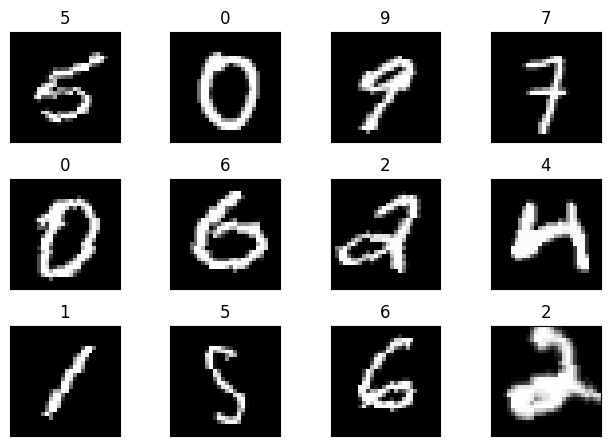

In [8]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [9]:
from models.model_1 import Net

In [10]:
# del Net

In [11]:
from utils import get_device
device = get_device()

In [12]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
              ReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 24, 24]          18,496
              ReLU-4           [-1, 64, 24, 24]               0
            Conv2d-5          [-1, 128, 22, 22]          73,856
              ReLU-6          [-1, 128, 22, 22]               0
         MaxPool2d-7          [-1, 128, 11, 11]               0
            Conv2d-8           [-1, 16, 11, 11]           2,064
            Conv2d-9             [-1, 32, 9, 9]           4,640
             ReLU-10             [-1, 32, 9, 9]               0
           Conv2d-11             [-1, 64, 7, 7]          18,496
             ReLU-12             [-1, 64, 7, 7]               0
           Conv2d-13            [-1, 128, 5, 5]          73,856
             ReLU-14            [-1, 12

/content/models/model_1.py:43: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


CODE BLOCK: 8

In [13]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [14]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)

    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()


    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 10

In [16]:
device = torch.cuda.current_device()
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion = F.nll_loss
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=2.2918 Batch_id=117 Accuracy=11.00: 100%|██████████| 118/118 [00:26<00:00,  4.53it/s]


Test set: Average loss: 2.2926, Accuracy: 1135/10000 (11.35%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=2.8319 Batch_id=117 Accuracy=27.02: 100%|██████████| 118/118 [00:26<00:00,  4.38it/s]


Test set: Average loss: 2.0290, Accuracy: 5258/10000 (52.58%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.3033 Batch_id=117 Accuracy=77.60: 100%|██████████| 118/118 [00:29<00:00,  3.97it/s]


Test set: Average loss: 0.2571, Accuracy: 9170/10000 (91.70%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.1017 Batch_id=117 Accuracy=93.50: 100%|██████████| 118/118 [00:30<00:00,  3.91it/s]


Test set: Average loss: 0.1318, Accuracy: 9584/10000 (95.84%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.1102 Batch_id=117 Accuracy=96.07: 100%|██████████| 118/118 [00:27<00:00,  4.28it/s]


Test set: Average loss: 0.1004, Accuracy: 9680/10000 (96.80%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.0714 Batch_id=117 Accuracy=96.89: 100%|██████████| 118/118 [00:26<00:00,  4.51it/s]


Test set: Average loss: 0.0915, Accuracy: 9688/10000 (96.88%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.0592 Batch_id=117 Accuracy=97.36: 100%|██████████| 118/118 [00:27<00:00,  4.33it/s]


Test set: Average loss: 0.0689, Accuracy: 9781/10000 (97.81%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.0440 Batch_id=117 Accuracy=97.75: 100%|██████████| 118/118 [00:25<00:00,  4.68it/s]


Test set: Average loss: 0.0728, Accuracy: 9760/10000 (97.60%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.1108 Batch_id=117 Accuracy=97.89: 100%|██████████| 118/118 [00:24<00:00,  4.90it/s]


Test set: Average loss: 0.0543, Accuracy: 9812/10000 (98.12%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.1146 Batch_id=117 Accuracy=98.06: 100%|██████████| 118/118 [00:24<00:00,  4.80it/s]


Test set: Average loss: 0.0484, Accuracy: 9834/10000 (98.34%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.1049 Batch_id=117 Accuracy=98.31: 100%|██████████| 118/118 [00:26<00:00,  4.48it/s]


Test set: Average loss: 0.0469, Accuracy: 9857/10000 (98.57%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.0961 Batch_id=117 Accuracy=98.43: 100%|██████████| 118/118 [00:25<00:00,  4.70it/s]


Test set: Average loss: 0.0454, Accuracy: 9846/10000 (98.46%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.0651 Batch_id=117 Accuracy=98.55: 100%|██████████| 118/118 [00:24<00:00,  4.85it/s]


Test set: Average loss: 0.0468, Accuracy: 9849/10000 (98.49%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.0569 Batch_id=117 Accuracy=98.62: 100%|██████████| 118/118 [00:23<00:00,  5.01it/s]


Test set: Average loss: 0.0440, Accuracy: 9850/10000 (98.50%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.0082 Batch_id=117 Accuracy=98.63: 100%|██████████| 118/118 [00:23<00:00,  5.04it/s]


Test set: Average loss: 0.0421, Accuracy: 9856/10000 (98.56%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0160 Batch_id=117 Accuracy=98.98: 100%|██████████| 118/118 [00:23<00:00,  5.08it/s]


Test set: Average loss: 0.0336, Accuracy: 9883/10000 (98.83%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0537 Batch_id=117 Accuracy=99.06: 100%|██████████| 118/118 [00:23<00:00,  5.04it/s]


Test set: Average loss: 0.0314, Accuracy: 9898/10000 (98.98%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0111 Batch_id=117 Accuracy=99.11: 100%|██████████| 118/118 [00:24<00:00,  4.80it/s]


Test set: Average loss: 0.0299, Accuracy: 9896/10000 (98.96%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0131 Batch_id=117 Accuracy=99.10: 100%|██████████| 118/118 [00:23<00:00,  4.93it/s]


Test set: Average loss: 0.0335, Accuracy: 9884/10000 (98.84%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0153 Batch_id=117 Accuracy=99.07: 100%|██████████| 118/118 [00:24<00:00,  4.84it/s]


Test set: Average loss: 0.0291, Accuracy: 9903/10000 (99.03%)

Adjusting learning rate of group 0 to 1.0000e-03.


CODE BLOCK: 11

Text(0.5, 1.0, 'Test Accuracy')

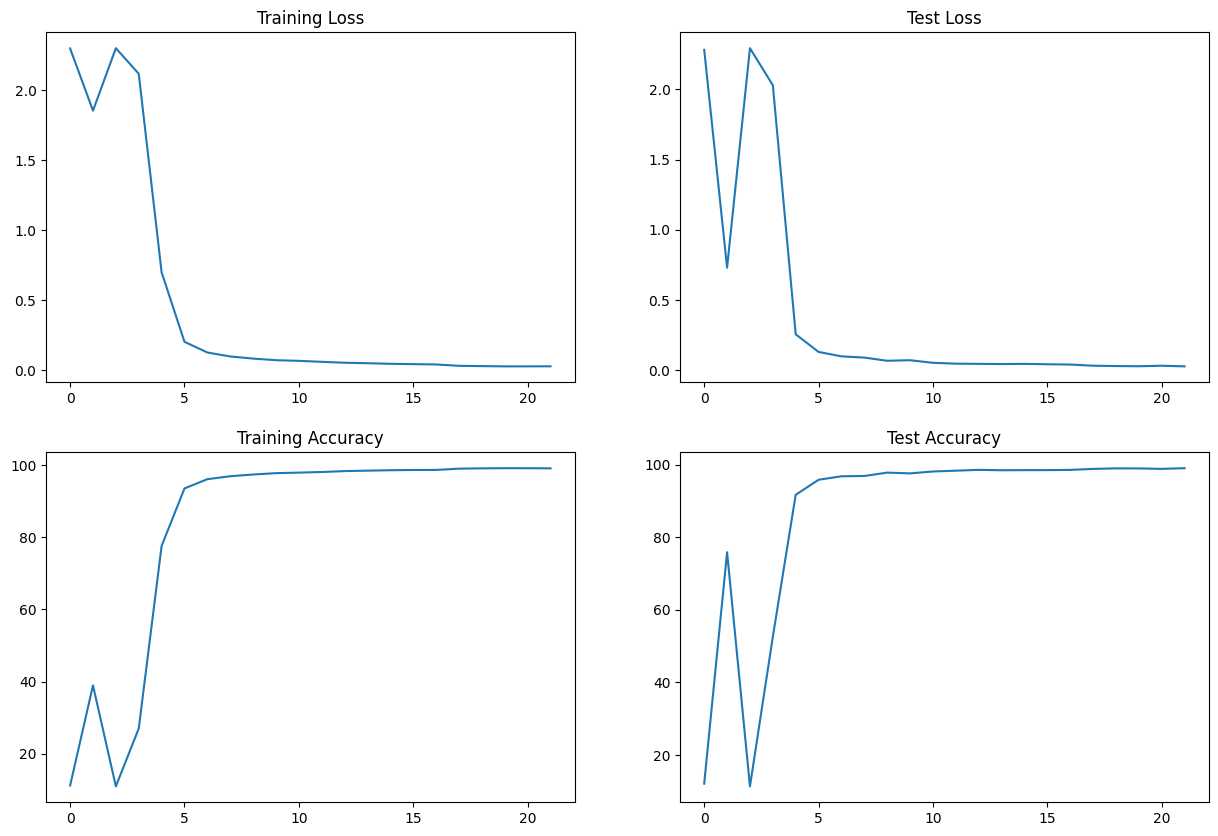

In [17]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")